In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

**Load libraries**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import copy
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
print(torch.cuda.is_available())

True


**Load the dataset**

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
torch.manual_seed(78)
# Load the Pneumonia dataset and apply the transformation pipeline
train_dataset = datasets.ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/train/', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/val/', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/test/', transform=transform)

# Create data loaders for the training, validation, and testing datasets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


In [6]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))
print("Number of test images:", len(test_dataset))
print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)
print(test_dataset.class_to_idx)

Number of training images: 5216
Number of validation images: 16
Number of test images: 624
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


**Define the student and teacher models**

In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Define the teacher model


class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.densenet = models.densenet121(pretrained=False)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=False)
        self.dropout2 = nn.Dropout(p=0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        features = self.densenet.features(x)
        features = self.dropout1(features)
        features = self.conv1(features)
        features = self.relu1(features)
        features = self.dropout2(features)
        features = self.maxpool(features)
        features = features.view(features.size(0), -1)
        x = nn.functional.relu(self.fc1(features))
        x = self.fc2(x)
        return x


# Define the student model
import torch.nn as nn
import torchvision.models as models



class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=False).features
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        features = self.mobilenet(x)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)
        x = nn.functional.relu(self.fc1(features))
        x = self.fc2(x)
        return x


In [8]:
print(train_dataset[0][0].shape)

torch.Size([3, 224, 224])


In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
teacher_net = TeacherModel().to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Train the teacher model**

In [11]:
import torch.optim as optim

learning_rate = 0.0001  # learning rate
momentum = 0.8 # momentum factor

optimizer_SGD = optim.SGD(teacher_net.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 0.1)


In [12]:
learning_rate = 0.0001
betas = (0.9, 0.999)
eps = 1e-08
optimizer_Adam = optim.Adam(teacher_net.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay = 0.1)


In [13]:
import torch.optim as optim

learning_rate = 0.0001


optimizer_Adagrad = optim.Adagrad(teacher_net.parameters(), lr=learning_rate, weight_decay = 0.1)


In [14]:
def train_teacher(optimizer):

    num_epochs = 25

    teacher_train_accs = []
    teacher_train_losses = []
    teacher_valid_accs = []
    teacher_valid_losses = []

    for epoch in range(num_epochs):
        train_loss, train_acc = 0, 0
        valid_loss, valid_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

        # Train set
        for i, data in enumerate(trainloader):

            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            teacher_outputs = teacher_net(images)
            
            loss = criterion(teacher_outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(teacher_outputs, dim=1) == labels)
            train_acc += acc

        # Validation set
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                teacher_outputs = teacher_net(images)
   
                loss = criterion(teacher_outputs,labels)
                valid_loss += loss.item()
                acc = torch.sum(torch.argmax(teacher_outputs, dim=1) == labels)
                valid_acc += acc

        train_loss /= len(trainloader)
        train_acc = float(train_acc) / len(trainloader.dataset) * 100

        valid_loss /= len(valloader)
        valid_acc = float(valid_acc) / len(valloader.dataset) * 100

        teacher_train_losses.append(train_loss)
        teacher_train_accs.append(train_acc)
        teacher_valid_losses.append(valid_loss)
        teacher_valid_accs.append(valid_acc)
        print("Train Loss: {0:.4f}, Train Accuracy: {1:.2f}%, Valid Loss: {2:.4f}, Valid Accuracy: {3:.2f}%".format(train_loss, train_acc, valid_loss, valid_acc))
        
    return teacher_train_losses, teacher_train_accs, teacher_valid_losses, teacher_valid_accs


In [15]:
teacher_train_losses, teacher_train_accs, teacher_valid_losses, teacher_valid_accs = train_teacher(optimizer_SGD)


Epoch:  1 / 25
Train Loss: 0.3926, Train Accuracy: 81.44%, Valid Loss: 1.0161, Valid Accuracy: 50.00%

Epoch:  2 / 25
Train Loss: 0.2587, Train Accuracy: 89.09%, Valid Loss: 1.2837, Valid Accuracy: 56.25%

Epoch:  3 / 25
Train Loss: 0.2171, Train Accuracy: 90.97%, Valid Loss: 1.1854, Valid Accuracy: 56.25%

Epoch:  4 / 25
Train Loss: 0.1930, Train Accuracy: 92.39%, Valid Loss: 1.0209, Valid Accuracy: 50.00%

Epoch:  5 / 25
Train Loss: 0.1780, Train Accuracy: 93.33%, Valid Loss: 1.0061, Valid Accuracy: 68.75%

Epoch:  6 / 25
Train Loss: 0.1638, Train Accuracy: 93.58%, Valid Loss: 1.2367, Valid Accuracy: 56.25%

Epoch:  7 / 25
Train Loss: 0.1500, Train Accuracy: 94.50%, Valid Loss: 1.1397, Valid Accuracy: 50.00%

Epoch:  8 / 25
Train Loss: 0.1447, Train Accuracy: 94.90%, Valid Loss: 1.1479, Valid Accuracy: 56.25%

Epoch:  9 / 25
Train Loss: 0.1356, Train Accuracy: 95.05%, Valid Loss: 1.3039, Valid Accuracy: 43.75%

Epoch:  10 / 25
Train Loss: 0.1311, Train Accuracy: 95.34%, Valid Loss: 

In [16]:
teacher_train_accs

[81.44171779141104,
 89.09125766871165,
 90.97009202453987,
 92.3888036809816,
 93.3282208588957,
 93.57745398773007,
 94.49769938650306,
 94.90030674846625,
 95.0536809815951,
 95.34125766871165,
 95.9930981595092,
 96.22315950920245,
 96.0122699386503,
 96.37653374233128,
 96.97085889570552,
 97.14340490797547,
 97.18174846625767,
 96.95168711656443,
 96.91334355828221,
 97.06671779141104,
 97.43098159509202,
 97.46932515337423,
 97.64187116564416,
 97.69938650306749,
 97.7760736196319]

In [17]:
teacher_valid_accs

[50.0,
 56.25,
 56.25,
 50.0,
 68.75,
 56.25,
 50.0,
 56.25,
 43.75,
 50.0,
 56.25,
 56.25,
 50.0,
 56.25,
 62.5,
 43.75,
 50.0,
 50.0,
 50.0,
 56.25,
 68.75,
 50.0,
 62.5,
 56.25,
 56.25]

In [18]:
teacher_train_losses

[0.39258870356744785,
 0.2586562009071188,
 0.21705036068426595,
 0.1930035739720005,
 0.17800575817586636,
 0.16384607084249747,
 0.15004138299549696,
 0.1446799125959468,
 0.13563095839648434,
 0.13112108930059782,
 0.11881702970156298,
 0.1093301373409633,
 0.10960194865810154,
 0.10563111274097503,
 0.0925782333211002,
 0.091724255903584,
 0.08684795718365834,
 0.08560993338569405,
 0.08827040108289295,
 0.08768293742401857,
 0.07912154805680817,
 0.07693783577497294,
 0.07506380312821823,
 0.07148327707081599,
 0.06764895632717347]

In [19]:
teacher_valid_losses

[1.0161181688308716,
 1.283698357641697,
 1.1854344233870506,
 1.0208887457847595,
 1.0061296820640564,
 1.2367414012551308,
 1.1396897062659264,
 1.1478711068630219,
 1.3038968294858932,
 1.3417542278766632,
 1.2558584585785866,
 1.3922562189400196,
 1.249700203537941,
 1.3059222139418125,
 1.221331313252449,
 1.2381644248962402,
 1.2054933458566666,
 1.2239648923277855,
 1.2305319756269455,
 1.225591242313385,
 1.2959399819374084,
 1.2398380432277918,
 1.1567499861121178,
 1.1580845899879932,
 1.0976386815309525]

**PLOT**

**Training vs Validation for teacher**

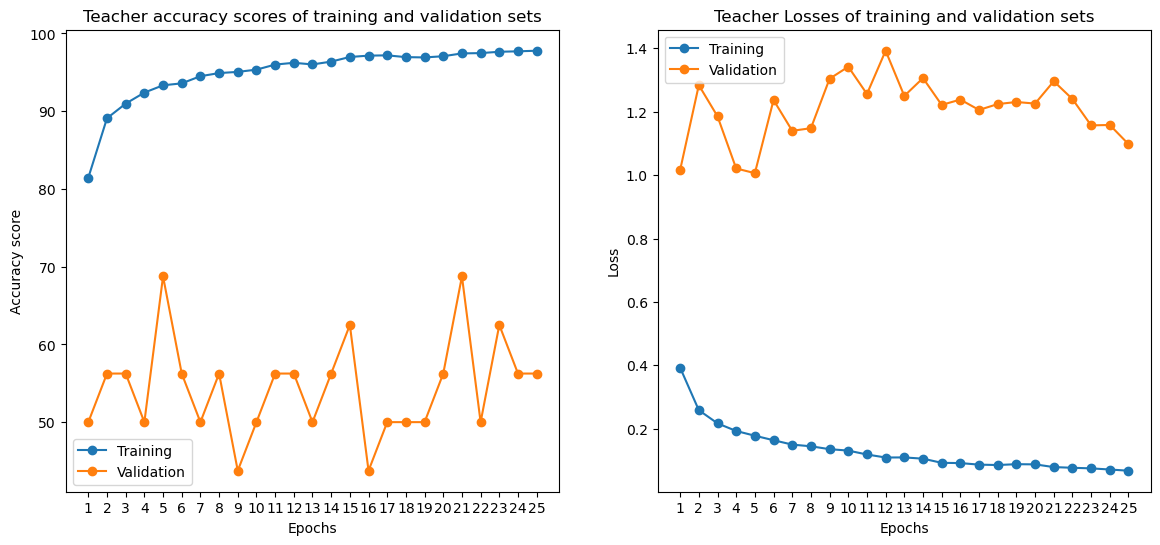

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 25
# Plot 1: Teacher accuracy scores of training and validation sets
ax1.plot([i+1 for i in range(num_epochs)], teacher_train_accs, label="Training", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], teacher_valid_accs, label="Validation", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Teacher accuracy scores of training and validation sets")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Teacher Losses of training and validation sets
ax2.plot([i+1 for i in range(num_epochs)], teacher_train_losses, label="Training", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], teacher_valid_losses, label="Validation", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Teacher Losses of training and validation sets")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

**Test the teacher model**

In [21]:
def evaluate(model, data_loader, device=device):
    model.eval()

    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss += nn.CrossEntropyLoss()(outputs, targets).item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).sum().item()

    loss /= len(data_loader)
    accuracy = 100. * correct / total

    return loss, accuracy


**Evaluating the performance on teacher network using testdata**

In [22]:
evaluate(teacher_net, testloader, device)

(0.4066012319272909, 80.12820512820512)

**Train the student model**

In [31]:

student_net = StudentModel().to(device)

In [32]:
import torch.optim as optim

learning_rate = 0.0001  # learning rate
momentum = 0.9  # momentum factor

optimizer_SGD = optim.SGD(student_net.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 0.1)


In [33]:
learning_rate = 0.0003
betas = (0.9, 0.999)
eps = 1e-08
optimizer_Adam = optim.Adam(student_net.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay = 0.1)


In [34]:
temperature = 4
alpha = 0.8

In [35]:
import torch
import torchvision.models as models

# Create an instance of the MobileNetV2 model
mobilenet = models.mobilenet_v2(pretrained=False)

# Check the expected input size by passing a dummy tensor through the model
dummy_input = torch.randn(1, 3, 224, 224)
output = mobilenet(dummy_input)
print("Expected input size:", dummy_input.size())


Expected input size: torch.Size([1, 3, 224, 224])


In [36]:
def train_student(optimizer):

    num_epochs = 25

    student_train_accs = []
    student_train_losses = []
    student_valid_accs = []
    student_valid_losses = []

    for epoch in range(num_epochs):
        train_loss, train_acc = 0, 0
        valid_loss, valid_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

        # Train set
        for i, data in enumerate(trainloader):

            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            teacher_outputs = teacher_net(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = 0.8*((nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha)) + 0.2* (nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc

        # Validation set
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                teacher_outputs = teacher_net(images)
                student_outputs = student_net(images)

                loss = 0.8*((nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha)) + 0.2* (nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha))

                valid_loss += loss.item()
                acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
                valid_acc += acc

        train_loss /= len(trainloader)
        train_acc = float(train_acc) / len(trainloader.dataset) * 100

        valid_loss /= len(valloader)
        valid_acc = float(valid_acc) / len(valloader.dataset) * 100

        student_train_losses.append(train_loss)
        student_train_accs.append(train_acc)
        student_valid_losses.append(valid_loss)
        student_valid_accs.append(valid_acc)
        print("Train Loss: {0:.4f}, Train Accuracy: {1:.2f}%, Valid Loss: {2:.4f}, Valid Accuracy: {3:.2f}%".format(train_loss, train_acc, valid_loss, valid_acc))
        
    return student_train_losses, student_train_accs, student_valid_losses, student_valid_accs


In [37]:
student_train_losses, student_train_accs, student_valid_losses, student_valid_accs = train_student(optimizer_SGD)


Epoch:  1 / 25
Train Loss: 0.2310, Train Accuracy: 74.41%, Valid Loss: 0.1014, Valid Accuracy: 50.00%

Epoch:  2 / 25
Train Loss: 0.1560, Train Accuracy: 80.58%, Valid Loss: 0.1259, Valid Accuracy: 50.00%

Epoch:  3 / 25
Train Loss: 0.1194, Train Accuracy: 84.24%, Valid Loss: 0.1221, Valid Accuracy: 43.75%

Epoch:  4 / 25
Train Loss: 0.1033, Train Accuracy: 86.22%, Valid Loss: 0.1485, Valid Accuracy: 50.00%

Epoch:  5 / 25
Train Loss: 0.0907, Train Accuracy: 88.31%, Valid Loss: 0.1331, Valid Accuracy: 50.00%

Epoch:  6 / 25
Train Loss: 0.0834, Train Accuracy: 89.09%, Valid Loss: 0.1347, Valid Accuracy: 56.25%

Epoch:  7 / 25
Train Loss: 0.0799, Train Accuracy: 89.11%, Valid Loss: 0.1318, Valid Accuracy: 62.50%

Epoch:  8 / 25
Train Loss: 0.0808, Train Accuracy: 89.53%, Valid Loss: 0.1290, Valid Accuracy: 56.25%

Epoch:  9 / 25
Train Loss: 0.0777, Train Accuracy: 89.70%, Valid Loss: 0.1164, Valid Accuracy: 56.25%

Epoch:  10 / 25
Train Loss: 0.0787, Train Accuracy: 89.49%, Valid Loss: 

In [38]:
student_train_accs

[74.40567484662577,
 80.57898773006134,
 84.24079754601227,
 86.21549079754601,
 88.30521472392638,
 89.09125766871165,
 89.11042944785275,
 89.53220858895705,
 89.704754601227,
 89.49386503067484,
 90.72085889570552,
 90.85506134969326,
 91.87116564417178,
 92.12039877300614,
 92.4463190184049,
 92.00536809815951,
 92.4463190184049,
 93.13650306748467,
 93.51993865030674,
 93.71165644171779,
 93.63496932515338,
 94.6127300613497,
 93.7308282208589,
 94.13343558282209,
 94.36349693251533]

In [39]:
student_valid_accs

[50.0,
 50.0,
 43.75,
 50.0,
 50.0,
 56.25,
 62.5,
 56.25,
 56.25,
 50.0,
 50.0,
 50.0,
 50.0,
 56.25,
 43.75,
 62.5,
 56.25,
 43.75,
 56.25,
 56.25,
 43.75,
 50.0,
 43.75,
 43.75,
 56.25]

In [40]:
student_train_losses

[0.23099633746214807,
 0.15601146565693105,
 0.11944798373851491,
 0.10331504193757392,
 0.09074937017703075,
 0.08339367806625787,
 0.07987414649544866,
 0.08082848853300229,
 0.07765109406389936,
 0.07872235195774105,
 0.0720312114993533,
 0.07213421488049343,
 0.06651280985350944,
 0.06230372537864498,
 0.06445040662081604,
 0.06389142801139526,
 0.06422636461832726,
 0.05945329967189146,
 0.06025661498828123,
 0.05792280924335076,
 0.05830038942830877,
 0.054552302308712,
 0.056649257240394144,
 0.05887842472882633,
 0.05742942292151824]

In [41]:
student_valid_losses

[0.10140568390488625,
 0.12587901949882507,
 0.12211985886096954,
 0.14847422391176224,
 0.1330796629190445,
 0.13468775898218155,
 0.1317974328994751,
 0.12895451113581657,
 0.11635658890008926,
 0.12163161486387253,
 0.10897965729236603,
 0.12211497500538826,
 0.1123629380017519,
 0.12401550263166428,
 0.11077521927654743,
 0.13936686888337135,
 0.10188011825084686,
 0.10859926789999008,
 0.10451474413275719,
 0.11445210501551628,
 0.1038367822766304,
 0.10308562219142914,
 0.09381591342389584,
 0.08848452568054199,
 0.08648483082652092]

**Test the student model**

In [42]:
evaluate(student_net, testloader, device)

(0.41310211901481336, 79.8076923076923)

**PLOTS**

**Training vs Validation for Student**

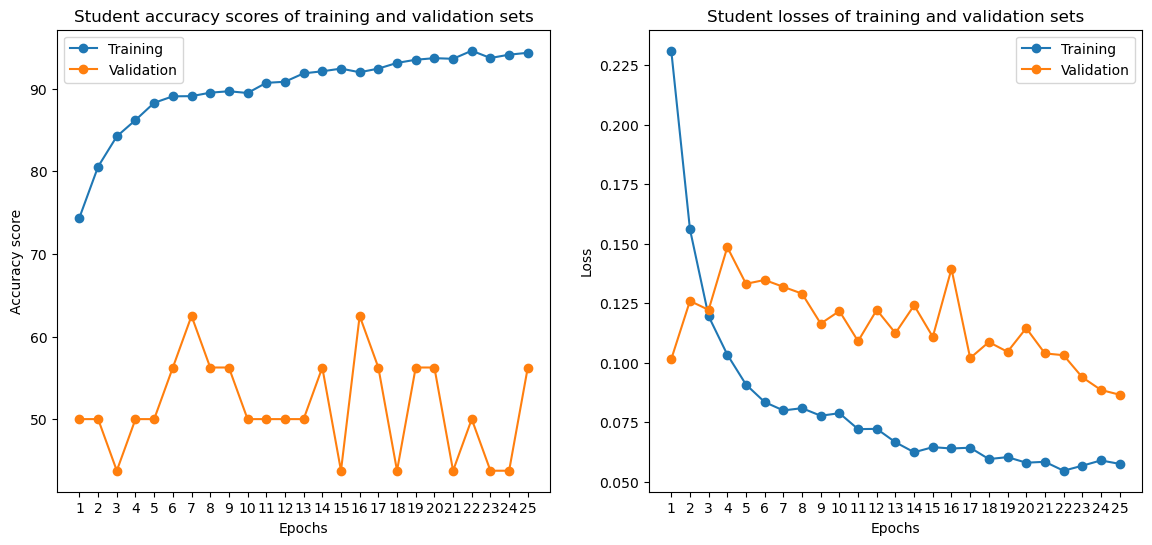

In [43]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 25
# Plot 1: Student accuracy scores of training and validation sets
ax1.plot([i+1 for i in range(num_epochs)], student_train_accs, label="Training", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_valid_accs, label="Validation", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Student accuracy scores of training and validation sets")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Student Losses of training and validation sets
ax2.plot([i+1 for i in range(num_epochs)], student_train_losses, label="Training", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_valid_losses, label="Validation", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Student losses of training and validation sets")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

**plots for comparing teacher and student models**

Accuracies

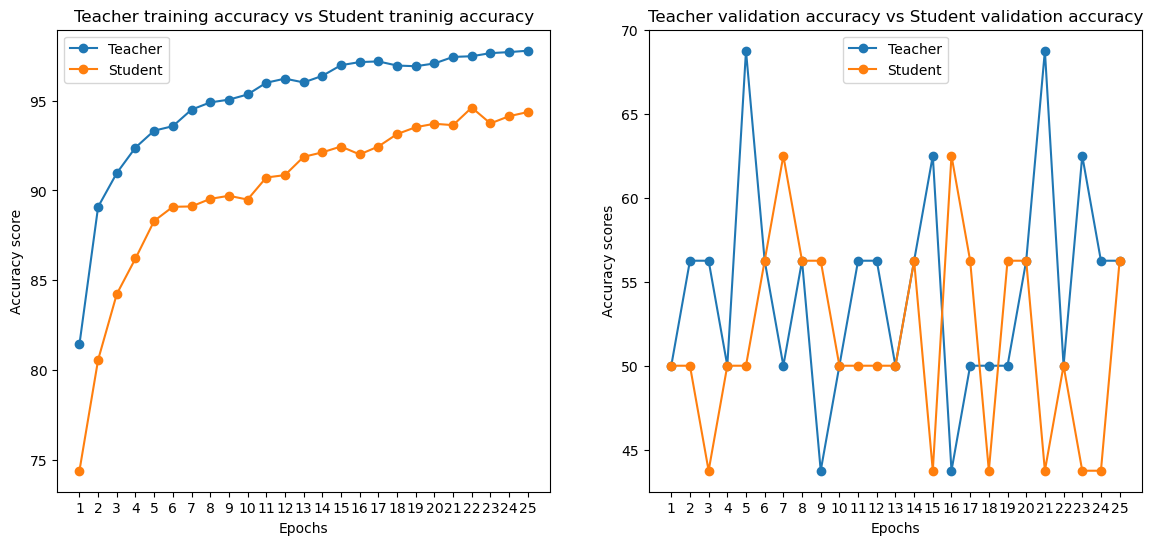

In [44]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 25
# Plot 1: Teacher training accuracy vs Student traninig accuracy
ax1.plot([i+1 for i in range(num_epochs)], teacher_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_train_accs, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Teacher training accuracy vs Student traninig accuracy")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Teacher validation accuracy vs Student validation accuracy
ax2.plot([i+1 for i in range(num_epochs)], teacher_valid_accs, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_valid_accs, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy scores")
ax2.set_title("Teacher validation accuracy vs Student validation accuracy")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

losses

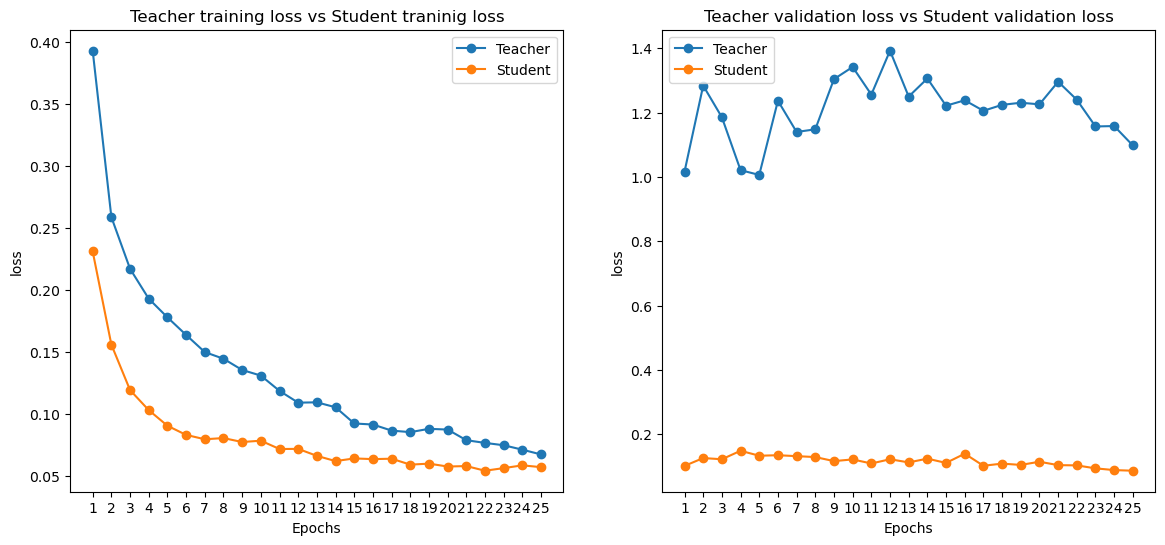

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 25
# Plot 1: Teacher training loss vs Student traninig loss
ax1.plot([i+1 for i in range(num_epochs)], teacher_train_losses, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_train_losses, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("loss")
ax1.set_title("Teacher training loss vs Student traninig loss")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Teacher validation losses vs Student validation losses
ax2.plot([i+1 for i in range(num_epochs)], teacher_valid_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_valid_losses, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("loss")
ax2.set_title("Teacher validation loss vs Student validation loss")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

**Without teacher model**

In [49]:
import torch.optim as optim

learning_rate = 0.0001  # learning rate
momentum = 0.8 # momentum factor

optimizer_SGD = optim.SGD(student_net.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 0.1)


In [50]:
def train_student_without_teacher(optimizer):

    num_epochs = 25

    student_noteacher_train_accs = []
    student_noteacher_train_losses = []
    student_noteacher_valid_accs = []
    student_noteacher_valid_losses = []

    for epoch in range(num_epochs):
        train_loss, train_acc = 0, 0
        valid_loss, valid_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

        # Train set
        for i, data in enumerate(trainloader):

            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            student_outputs = student_net(images)
            
            loss = criterion(student_outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc

        # Validation set
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                student_outputs = student_net(images)
   
                loss = criterion(student_outputs,labels)
                valid_loss += loss.item()
                acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
                valid_acc += acc

        train_loss /= len(trainloader)
        train_acc = float(train_acc) / len(trainloader.dataset) * 100

        valid_loss /= len(valloader)
        valid_acc = float(valid_acc) / len(valloader.dataset) * 100

        student_noteacher_train_losses.append(train_loss)
        student_noteacher_train_accs.append(train_acc)
        student_noteacher_valid_losses.append(valid_loss)
        student_noteacher_valid_accs.append(valid_acc)
        print("Train Loss: {0:.4f}, Train Accuracy: {1:.2f}%, Valid Loss: {2:.4f}, Valid Accuracy: {3:.2f}%".format(train_loss, train_acc, valid_loss, valid_acc))
        
    return student_noteacher_train_losses, student_noteacher_train_accs, student_noteacher_valid_losses, student_noteacher_valid_accs


In [51]:
student_noteacher_train_losses, student_noteacher_train_accs, student_noteacher_valid_losses, student_noteacher_valid_accs = train_student_without_teacher(optimizer_SGD)


Epoch:  1 / 25
Train Loss: 0.6521, Train Accuracy: 72.18%, Valid Loss: 0.7899, Valid Accuracy: 50.00%

Epoch:  2 / 25
Train Loss: 0.5833, Train Accuracy: 74.29%, Valid Loss: 0.9401, Valid Accuracy: 50.00%

Epoch:  3 / 25
Train Loss: 0.5793, Train Accuracy: 74.29%, Valid Loss: 0.7874, Valid Accuracy: 50.00%

Epoch:  4 / 25
Train Loss: 0.5769, Train Accuracy: 74.29%, Valid Loss: 0.7991, Valid Accuracy: 50.00%

Epoch:  5 / 25
Train Loss: 0.5717, Train Accuracy: 74.29%, Valid Loss: 0.8892, Valid Accuracy: 50.00%

Epoch:  6 / 25
Train Loss: 0.5507, Train Accuracy: 74.29%, Valid Loss: 0.8832, Valid Accuracy: 50.00%

Epoch:  7 / 25
Train Loss: 0.5408, Train Accuracy: 74.29%, Valid Loss: 0.9400, Valid Accuracy: 50.00%

Epoch:  8 / 25
Train Loss: 0.5326, Train Accuracy: 74.29%, Valid Loss: 0.7860, Valid Accuracy: 50.00%

Epoch:  9 / 25
Train Loss: 0.5321, Train Accuracy: 74.29%, Valid Loss: 0.9344, Valid Accuracy: 50.00%

Epoch:  10 / 25
Train Loss: 0.5094, Train Accuracy: 74.39%, Valid Loss: 

**Comparision between Student without and with teacher**

Training set

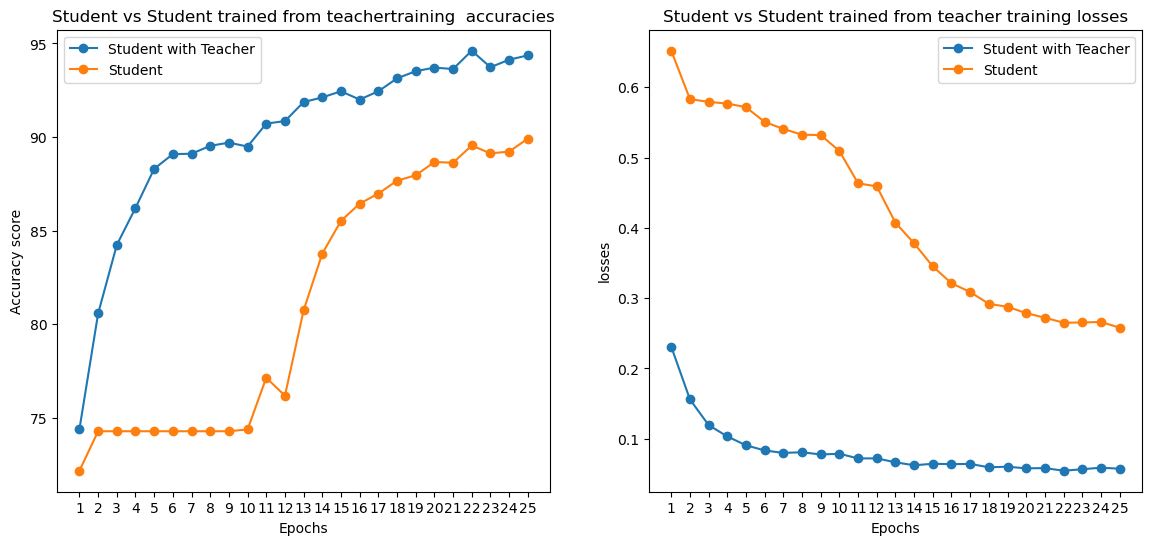

In [54]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 25
# Plot 1: Student vs Student trained from teacher accuracies
ax1.plot([i+1 for i in range(num_epochs)], student_train_accs, label="Student with Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_noteacher_train_accs, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Student vs Student trained from teachertraining  accuracies")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Student vs Student trained from teacher losses
ax2.plot([i+1 for i in range(num_epochs)], student_train_losses, label="Student with Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_noteacher_train_losses, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("losses")
ax2.set_title("Student vs Student trained from teacher training losses")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

validation set

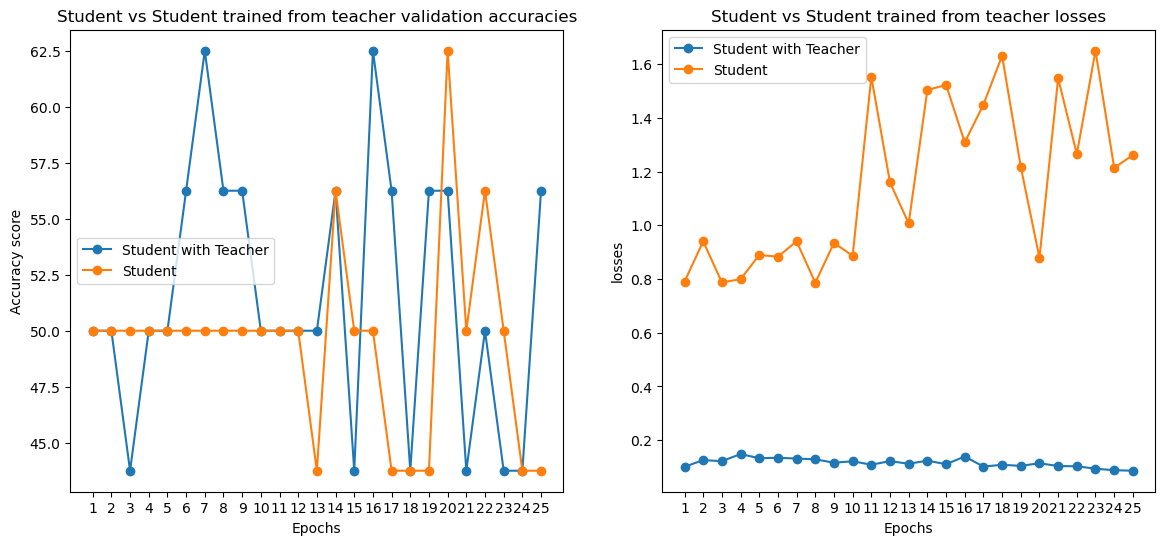

In [55]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 25
# Plot 1: Student vs Student trained from teacher validation accuracies
ax1.plot([i+1 for i in range(num_epochs)], student_valid_accs, label="Student with Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_noteacher_valid_accs, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Student vs Student trained from teacher validation accuracies")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Student vs Student trained from teacher validation losses
ax2.plot([i+1 for i in range(num_epochs)], student_valid_losses, label="Student with Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_noteacher_valid_losses, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("losses")
ax2.set_title("Student vs Student trained from teacher losses")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()